<a href="https://colab.research.google.com/github/yskim5892/AI_Expert_2022/blob/main/Lab2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logic Gate Example


In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class SeparatorMLP(nn.Module):
  def __init__(self):
    super(SeparatorMLP, self).__init__()
    self.fc1 = nn.Linear(2, 2)
    self.fc2 = nn.Linear(2, 1)
  
  def forward(self, x):
    x = self.fc1(x)
    x = nn.functional.sigmoid(x)
    x = self.fc2(x)
    x = torch.sigmoid(x)
    return x

In [3]:
class Separator(nn.Module):
  def __init__(self,func=None):
    super(Separator, self).__init__()
    self.a = torch.nn.Parameter(torch.Tensor([np.random.normal()]))
    self.b = torch.nn.Parameter(torch.Tensor([np.random.normal()]))
    self.c = torch.nn.Parameter(torch.Tensor([np.random.normal()]))
    if func is not None:
      self.func = func
    else:
      self.func = torch.sigmoid
  
  def forward(self, x):
    val_ = self.func(self.a * x[:,0] + self.b * x[:,1] - self.c).unsqueeze(-1)
    return val_

In [4]:
class DataGenerator(Dataset):
  def __init__(self, type_, length, std=0.08):
    self.length = length
    if type_ == 'and':
      self.val_l = [0, 0, 0, 1]
    elif type_ == 'or':
      self.val_l = [0, 1, 1, 1]
    elif type_ == 'xor':
      self.val_l = [0, 1, 1, 0]
    else:
      self.val_l = [0, 0, 0, 0]
     
    self.dataset = []
    for i in range(length):
      x = np.random.normal(i%2, std)
      y = np.random.normal((i//2)%2, std)
      val = self.val_l[i%4]
      self.dataset.append((x, y, val))
      
  def get_dataset(self):
    return self.dataset
    
  def __len__(self):
    return self.length
    
  def __getitem__(self, idx):
    x, y, val = self.dataset[idx]
    return (torch.Tensor([x, y]), torch.Tensor([val]))

In [5]:
DATASET = DataGenerator('and', 1000)
lr = 0.01 # learning rate
batch_size = 20
num_epochs = 30
num_workers = 4
graph_x = np.linspace(-1.0, 2, 2)

params = {
    'batch_size' : batch_size,
    'shuffle' : True,
    'num_workers' : num_workers
}

dataloader = DataLoader(DATASET, **params)
model = Separator().cuda()
optimizer = Adam(model.parameters(), lr=lr)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


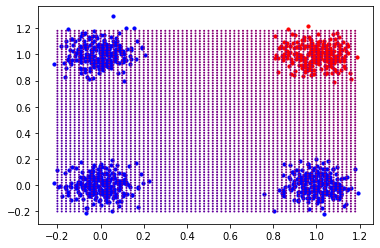

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss : 0.16333
Loss : 0.13775
Loss : 0.11852
Loss : 0.10404
Loss : 0.09234


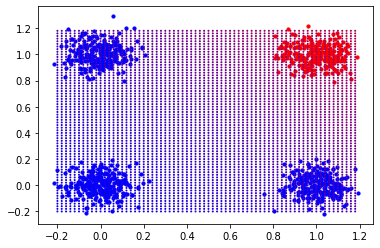

Loss : 0.08284
Loss : 0.07486
Loss : 0.06802
Loss : 0.06206
Loss : 0.05692


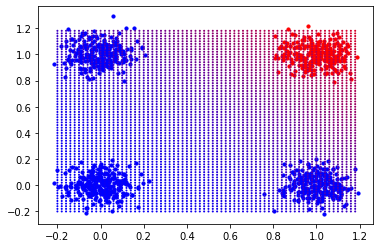

Loss : 0.05240
Loss : 0.04832
Loss : 0.04478
Loss : 0.04158
Loss : 0.03865


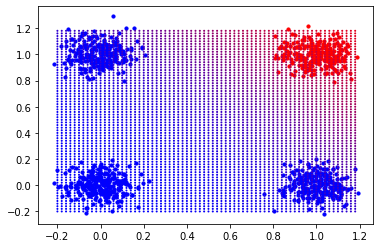

Loss : 0.03605
Loss : 0.03369
Loss : 0.03152
Loss : 0.02956
Loss : 0.02779


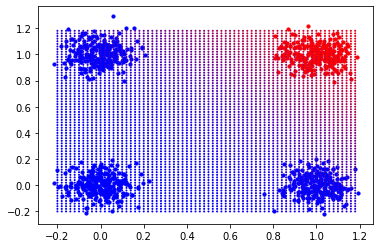

Loss : 0.02617
Loss : 0.02467
Loss : 0.02326
Loss : 0.02201
Loss : 0.02082


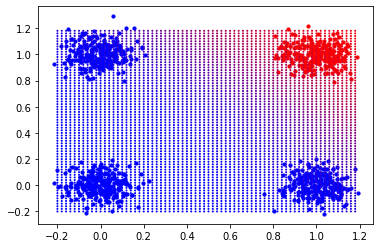

Loss : 0.01977
Loss : 0.01877
Loss : 0.01783
Loss : 0.01697
Loss : 0.01617


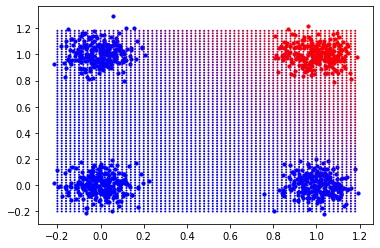

In [6]:
def show(model):
  for item in DATASET.get_dataset():
    x, y, val = item
    if val == 1:
      plt.scatter(x, y, c='red', s=10)
    else:
      plt.scatter(x, y, c='blue', s=10)
  t = torch.arange(70,dtype=torch.float32)*0.02-0.2
  x = t.unsqueeze(0).repeat(70,1).unsqueeze(-1)
  y = t.unsqueeze(1).repeat(1,70).unsqueeze(-1)
  data = torch.cat((x,y),-1).view(-1,2)
  with torch.no_grad():
    val = (model(data.cuda())).cpu()
  colors = torch.cat((val,torch.zeros_like(val),1-val),-1).numpy()
  plt.scatter(data.numpy()[:,0],data.numpy()[:,1], c=colors, s=1)
  plt.show()

show(model)
for epoch in range(num_epochs):
  total_loss = 0
  for x, val in dataloader:
    x = x.cuda()
    val = val.cuda()
    optimizer.zero_grad()
    val_ =  model(x)
    loss = torch.sum(torch.pow(val - val_, 2))
    
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print("Loss : {:.5f}".format(total_loss / len(DATASET)))
  
  if epoch % 5  == 4:
    model.eval()
    show(model)
    model.train()